## Fashion shop recommendation 


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from scipy.sparse import coo_matrix, hstack

## Part 0.Dataset

In [2]:
test = pd.read_csv("hw5_data_test.csv")
train = pd.read_csv("hw5_data_train.csv")

In [3]:
test.head()

,Title,Review,Recommended
0,NaN,NaN,0
1,Perfect pair!!,This pair of age stevie capris is everything t...,1
2,Talk about creature comforts!,This is a beautifully designed jacket that eve...,1
3,NaN,NaN,1
4,So comfotable,I ordered this dress in 0p since i am 5ft. it ...,1


In [4]:
train["tr"] = train["Title"].map(str) + " " + train["Review"]
test["tr"] = test["Title"].map(str) + " " + test["Review"]

In [5]:
train_title = train[['Title']]
train_review = train[['Review']]
train_tr = train[["tr"]]
train_label = train[['Recommended']]
print(train_title.shape, train_review.shape, train_tr.shape,train_label.shape)
print("train label balance: {}".format(np.bincount(train_label['Recommended'].values)))

(17614, 1) (17614, 1) (17614, 1) (17614, 1)
train label balance: [ 3129 14485]


In [6]:
test_title = test[['Title']]
test_review = test[['Review']]
test_tr = test[["tr"]]
test_label = test[['Recommended']]
print(test_title.shape, test_review.shape, test_tr.shape, test_label.shape)
print("test label balance: {}".format(np.bincount(test_label['Recommended'].values)))

(5872, 1) (5872, 1) (5872, 1) (5872, 1)
test label balance: [1043 4829]


In [7]:
train_title['Title'].values.astype('U')

array(['Beautiful unique dress', 'Had high hopes but...',
       'Buttons -buttons so cute!', ..., 'nan', 'So pleased',
       'Beautiful, flowy,'], dtype='<U52')

## Part 1. Title and body

### 1.1 Use the title only
#### a. Use CountVectorizer with the default settings and train a linear classifier. 

In [24]:
vect = CountVectorizer()
vect.fit(train_title['Title'].values.astype('U'))
train_title_vect = vect.transform(train_title['Title'].values.astype('U'))

test_title_vect = vect.transform(test_title['Title'].values.astype('U'))
print(train_title_vect.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [33]:
lr = LogisticRegression()
lr.fit(train_title_vect, train_label)
lr_title_train_score = cross_validate(lr, train_title_vect, train_label, scoring='roc_auc')
print("Title---LR with CountVectorizer(train): {:.3f}".format(np.mean(lr_title_train_score['train_score'])))
print("Title---LR with CountVectorizer(test): {:.3f}".format(np.mean(lr_title_train_score['test_score'])))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Title---LR with CountVectorizer(train): 0.932
Title---LR with CountVectorizer(test): 0.887


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [9]:
# lr_title = LogisticRegressionCV(scoring=('roc_auc')).fit(train_title_vect, train_label)
# print("Title---LR with CountVectorizer(test): {:.3f}".format(lr_title.score(test_title_vect, test_label)))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Title---LR with CountVectorizer: 0.878


In [27]:
test_title_vect.shape

(5872, 3220)

In [28]:
feature_names = vect.get_feature_names()

In [29]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

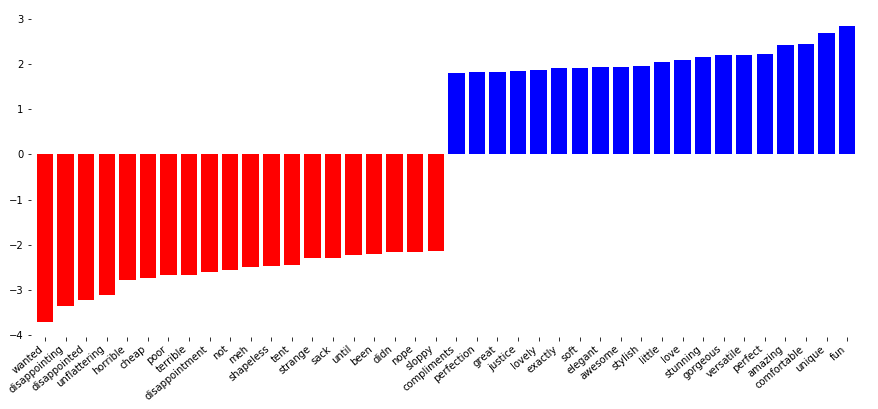

In [36]:
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### b.Tune the regularization parameter of the classifier

In [168]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_title_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_title_grid.fit(train_title_vect, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [218]:
print(lr_title_grid.best_params_)
print("Title---LR(tuned) with CountVectorizer(train):{:.3f}".format(lr_title_grid.best_score_))
#print("Title---LR(tuned) with CountVectorizer(test):{:.3f}".format(lr_title_grid.score(test_title_vect, test_label)))

{'C': 1.438449888287663}
Title---LR(tuned) with CountVectorizer(train):0.893


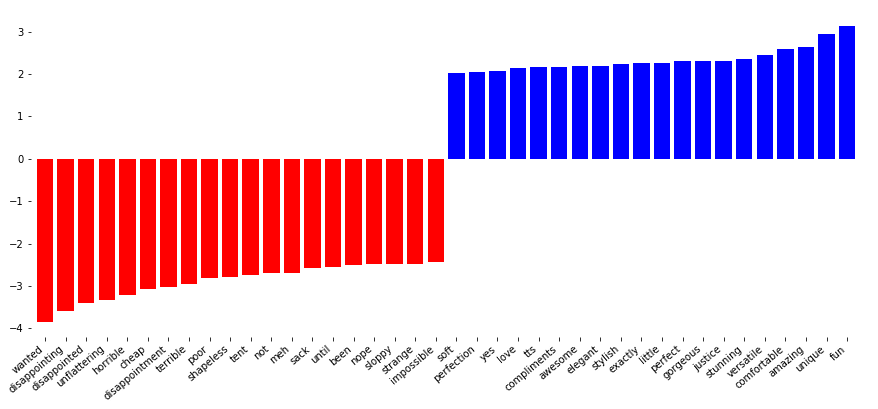

In [16]:
plt.figure(figsize=(15, 6))
plot_important_features(lr_title_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

### 1.2 Use the review body only

#### a. Without tuning

In [38]:
vect2 = CountVectorizer()
vect2.fit(train_review['Review'].values.astype('U'))
train_review_vect = vect2.transform(train_review['Review'].values.astype('U'))

test_review_vect = vect2.transform(test_review['Review'].values.astype('U'))
print(train_review_vect.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [39]:
train_review_vect.shape, test_review_vect.shape

((17614, 12554), (5872, 12554))

In [40]:
lr_review = LogisticRegression()
lr_review.fit(train_review_vect, train_label)
lr_review_train_score = cross_validate(lr_review, train_review_vect, train_label, scoring='roc_auc')
print("Review---LR with CountVectorizer(train): {:.3f}".format(np.mean(lr_review_train_score['train_score'])))
print("Review---LR with CountVectorizer(train): {:.3f}".format(np.mean(lr_review_train_score['test_score'])))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Review---LR with CountVectorizer(train): 0.991
Review---LR with CountVectorizer(train): 0.909


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [180]:
# lr_review = LogisticRegressionCV(scoring=('roc_auc')).fit(train_review_vect, train_label)
# print("Review---LR with CountVectorizer: {:.3f}".format(lr_review.score(test_review_vect, test_label)))

Review---LR with CountVectorizer: 0.887


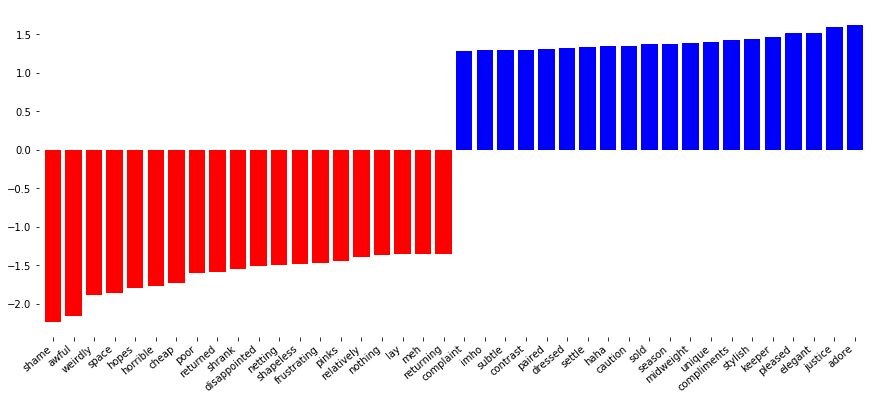

In [41]:
feature_names = vect2.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_review.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### b. Tuning

In [182]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_review_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_review_grid.fit(train_review_vect, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [222]:
print("Review---LR(tuned) with CountVectorizer:{:.3f}".format(lr_review_grid.best_score_))

Review---LR(tuned) with CountVectorizer:0.925


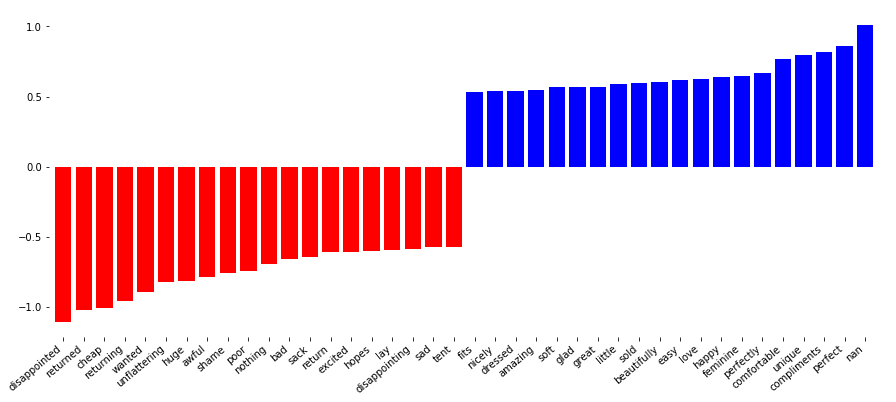

In [223]:
feature_names = vect2.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_review_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

### 1.3 Use the review and title

In [8]:
vect3 = CountVectorizer()
vect3.fit(train_tr['tr'].values.astype('U'))
train_tr_vect = vect3.transform(train_tr['tr'].values.astype('U'))

test_tr_vect = vect3.transform(test_tr['tr'].values.astype('U'))
print(train_tr_vect.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [9]:
train_tr_vect.shape,test_tr_vect.shape

((17614, 13011), (5872, 13011))

In [42]:
lr_tr = LogisticRegression()
lr_tr.fit(train_tr_vect, train_label)
lr_tr_train_score = cross_validate(lr_tr, train_tr_vect, train_label, scoring='roc_auc')
print("Title + Review---LR with CountVectorizer(train): {:.3f}".format(np.mean(lr_tr_train_score['train_score'])))
print("Title + Review---LR with CountVectorizer(test): {:.3f}".format(np.mean(lr_tr_train_score['test_score'])))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Title + Review---LR with CountVectorizer(train): 0.994
Title + Review---LR with CountVectorizer(test): 0.927


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [188]:
# lr_tr = LogisticRegressionCV(scoring=('roc_auc')).fit(train_tr_vect, train_label)
# print("Title and Review---LR with CountVectorizer: {:.3f}".format(lr_tr.score(test_tr_vect, test_label)))

Title and Review---LR with CountVectorizer: 0.895


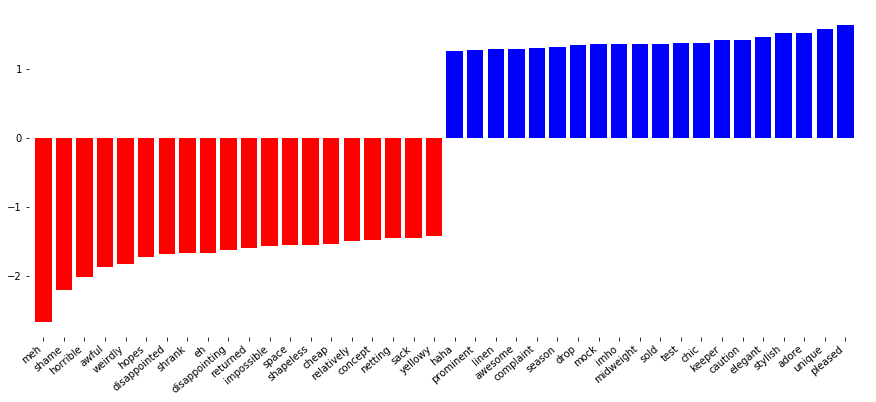

In [43]:
feature_names = vect3.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_tr.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### b.Tuning

In [228]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tr_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tr_grid.fit(train_tr_vect, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [229]:
print("Title and Review---LR(tuned) with CountVectorizer:{:.3f}".format(lr_tr_grid.best_score_))

Title and Review---LR(tuned) with CountVectorizer:0.940


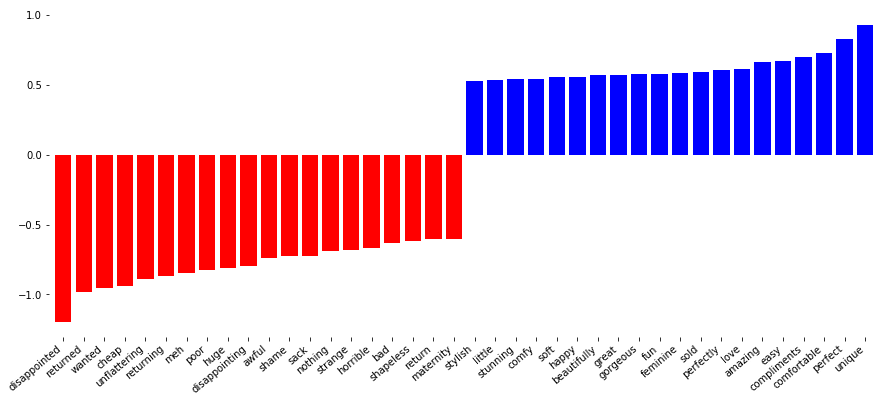

In [230]:
feature_names = vect.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_tr_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

### 1.4 Vectorizing title and review individually and concatenating the vector representations

#### a. Withpout tuning

In [44]:
vect_title = CountVectorizer()
vect_title.fit(train_title['Title'].values.astype('U'))
train_title_vect_token= vect_title.transform(train_title['Title'].values.astype('U'))
test_title_vect_token = vect_title.transform(test_title['Title'].values.astype('U'))

vect_review = CountVectorizer()
vect_review.fit(train_review['Review'].values.astype('U'))
train_review_vect_token= vect_review.transform(train_review['Review'].values.astype('U'))
test_review_vect_token = vect_review.transform(test_review['Review'].values.astype('U'))


In [45]:
train_title_vect_token.shape, train_review_vect_token.shape, test_title_vect_token.shape, test_review_vect_token.shape, 

((17614, 3220), (17614, 12554), (5872, 3220), (5872, 12554))

In [46]:
train_tr_vect_token = hstack([train_title_vect_token, train_review_vect_token])
test_tr_vect_token = hstack([test_title_vect_token, test_review_vect_token])
train_tr_vect_token.shape, test_tr_vect_token.shape

((17614, 15774), (5872, 15774))

In [47]:
lr_t_r = LogisticRegression()
lr_t_r.fit(train_tr_vect_token, train_label)

lr_tr_train_token_score = cross_validate(lr_t_r, train_tr_vect_token, train_label, scoring='roc_auc')
print("Title + Review---LR with CountVectorizer token (train): {:.3f}"\
      .format(np.mean(lr_tr_train_token_score['train_score'])))
print("Title + Review---LR with CountVectorizer token (test): {:.3f}"\
      .format(np.mean(lr_tr_train_token_score['test_score'])))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Title + Review---LR with CountVectorizer token (train): 0.996
Title + Review---LR with CountVectorizer token (test): 0.930


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


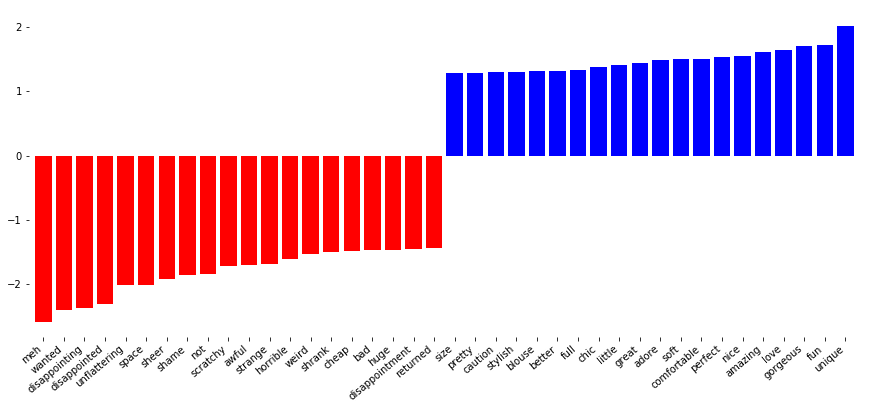

In [49]:
feature_names = vect_title.get_feature_names()+vect_review.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_t_r.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

In [205]:
# lr_tr_token = LogisticRegressionCV(scoring=('roc_auc')).fit(train_tr_vect_token, train_label)
# print("Title and Review---LR with CountVectorizer with token pattern: {:.3f}"\
#       .format(lr_tr_token.score(test_tr_vect_token, test_label)))

#### b.Tuning

In [208]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tr_token_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tr_token_grid.fit(train_tr_vect_token, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [211]:
print("Title and Review---LR(tuned) with CountVectorizer with token pattern:{:.3f}"\
      .format(lr_tr_token_grid.best_score_))

Title and Review---LR(tuned) with CountVectorizer with token pattern:0.942


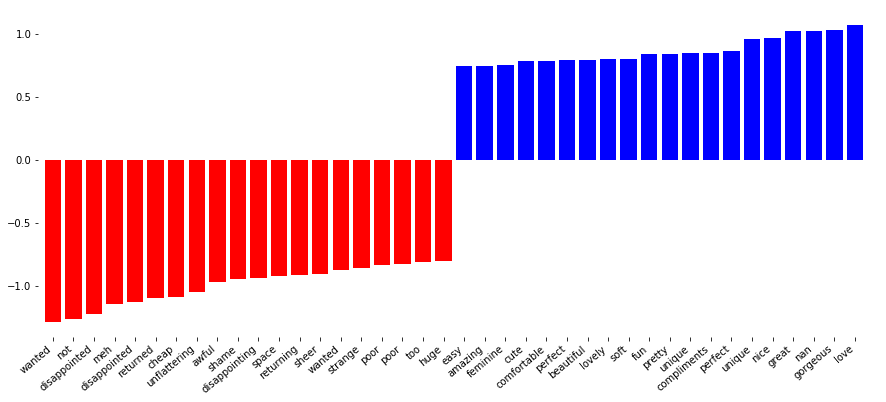

In [212]:

feature_names = vect_title.get_feature_names() + vect_review.get_feature_names()

plt.figure(figsize=(15, 6))
plot_important_features(lr_tr_token_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### After tuning, we found that conbining title + body and verctoring title +body have the similar score. Thus, we will use those two to get the test score

In [234]:
print("task 1.3---Title and Review---LR(tuned) with CountVectorizer :{:.3f}"\
      .format(lr_tr_grid.score(test_tr_vect, test_label)))


print("task 1.4---Title and Review---LR(tuned) with CountVectorizer with vectoring :{:.3f}"\
      .format(lr_tr_token_grid.score(test_tr_vect_token, test_label)))

task 1.3---Title and Review---LR(tuned) with CountVectorizer :0.935
task 1.4---Title and Review---LR(tuned) with CountVectorizer with vectoring :0.938


## 2 Feature Tuning (30Pts)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

In [9]:
text_trainval, train_label = train_tr['tr'].values.astype('U'),np.array(train[['Recommended']]).ravel()
text_testval, test_label = test_tr['tr'].values.astype('U'), np.array(test[['Recommended']]).ravel()

#### 2.1 Try using TfidfVectorizer instead of CountVectorizer. Does it change the score? Does it change the important coefficients?

Score got improved by using TfidfVectorizer. And important coefficients changed.

In [10]:
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(text_trainval)
test_tfidf = tfidf.transform(text_testval)
print(train_tfidf.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [11]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tfidf1_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tfidf1_grid.fit(train_tfidf, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [12]:
print("parameter:", lr_tfidf1_grid.best_params_)
print("default tfidf training score :", lr_tfidf1_grid.best_score_)

parameter: {'C': 2.976351441631316}
default tfidf training score : 0.9487037087758139


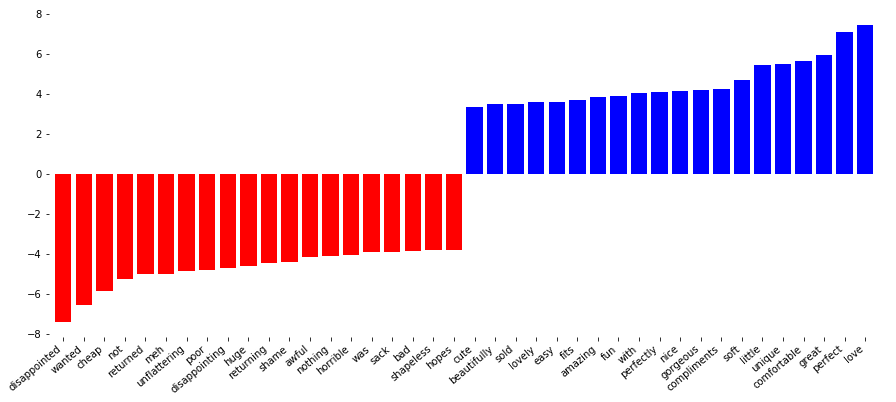

In [18]:
feature_names = tfidf.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf1_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### 2.2 Remember that TfidfVectorizer uses normalization by default. Does using a Normalizer with CountVectorizer change the outcome?

Answer: Normalizer with countvectorizer changes the outcome a little bit. Training Set score is 0.9467 in this setting.

In [13]:
vect = CountVectorizer()
X_train = vect.fit_transform(text_trainval)
X_test = vect.transform(text_testval)
print(X_train.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
from sklearn.preprocessing import MaxAbsScaler, Normalizer
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X_train)
normalizer = Normalizer()
X_normalized = normalizer.fit_transform(X_train)
X_test_normalized = normalizer.transform(scaler.transform(X_test))

In [15]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_cv_normalized_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_cv_normalized_grid.fit(X_normalized, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [19]:
print("parameter:", lr_cv_normalized_grid.best_params_)
print("cv_normalized training score :", lr_cv_normalized_grid.best_score_)

parameter: {'C': 12.742749857031322}
cv_normalized training score : 0.9467479653029574


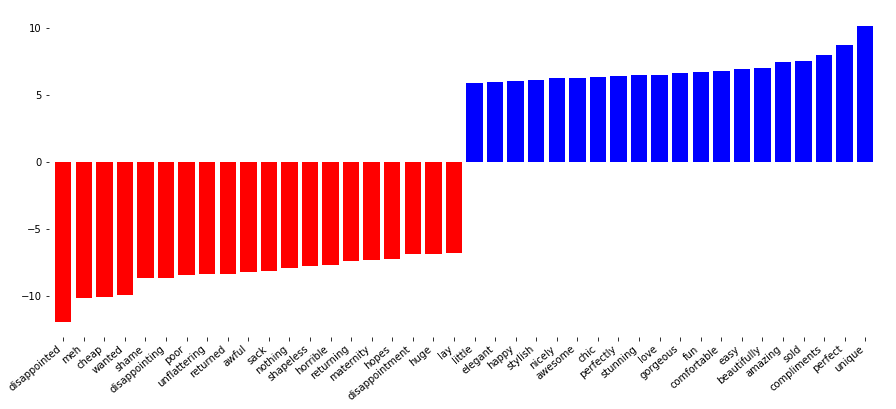

In [20]:
feature_names = vect.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_cv_normalized_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### 2.3 Try using stop-word. Do the standard English stop-words help? Why / why not?

Answer: Standard English stop-words do not help which can be seen from training set roc socre. Score of Tfidf with sw is 0.9417.

In [21]:
tfidf_sw = TfidfVectorizer(stop_words='english')
X_train_tfidf_sw = tfidf_sw.fit_transform(text_trainval)
X_val_tfidf_sw = tfidf_sw.transform(text_testval)

In [22]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tfidf_sw_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tfidf_sw_grid.fit(X_train_tfidf_sw, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [23]:
print("parameter:", lr_tfidf_sw_grid.best_params_)
print("tfidf_sw training score :", lr_tfidf_sw_grid.best_score_)

parameter: {'C': 1.438449888287663}
tfidf_sw training score : 0.9417713284190165


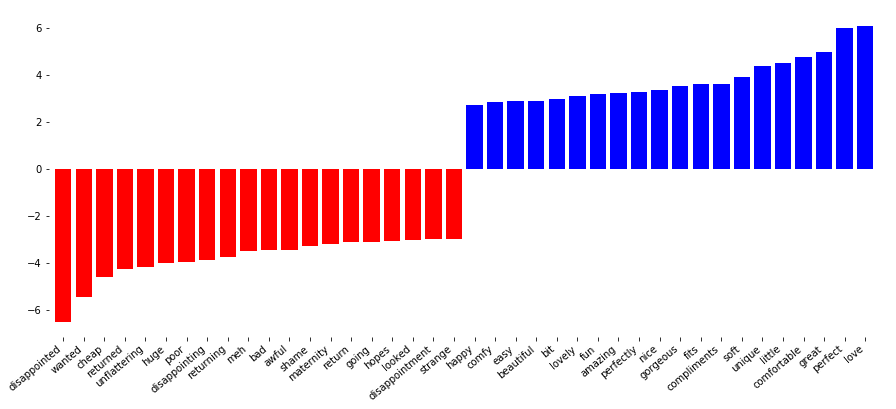

In [24]:
feature_names = tfidf_sw.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_sw_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

#### 2.4 Limit the vocabulary using min_df or max_df. How to these impact the number of features, and how do they impact the scores?

Answer: Feature number decreases dramatically with min_df value from 1 to 4, while classifier score does not change too much, it keeps around 0.9487.(min_df = 3, 'C': 2.976 achieves the best score which is  0.9488)

With max_df, feature number decrease with smaller max_df value but scores are not as good as before, the best score it can achieve is 0.918

In [25]:
tfidf = TfidfVectorizer(min_df=2)
X_train_tfidf2 = tfidf.fit_transform(text_trainval)
X_val_tfidf2 = tfidf.transform(text_testval)
print(train_tfidf.shape)
print(X_train_tfidf2.shape)

(17614, 13011)
(17614, 7478)


In [26]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tfidf_min2_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tfidf_min2_grid.fit(X_train_tfidf2, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
print("parameter:", lr_tfidf_min2_grid.best_params_)
print("tfidf_min2 training score :", lr_tfidf_min2_grid.best_score_)

parameter: {'C': 2.976351441631316}
tfidf_min2 training score : 0.9487598612288531


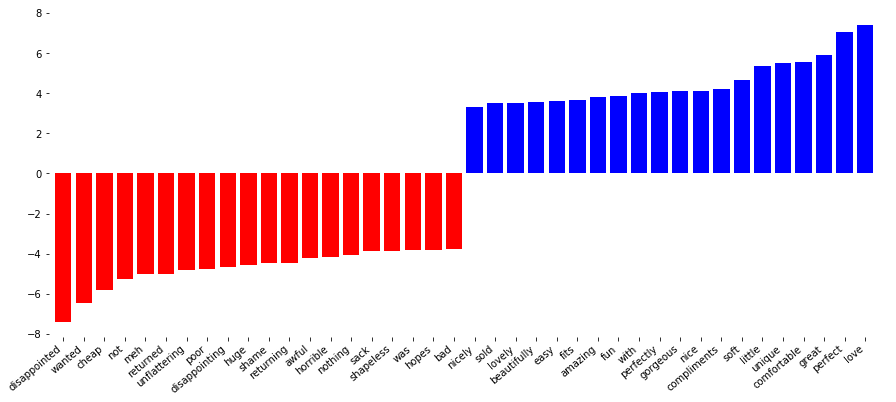

In [28]:
feature_names = tfidf.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_min2_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

In [32]:
tfidf = TfidfVectorizer(min_df=3)
X_train_tfidf3 = tfidf.fit_transform(text_trainval)
X_val_tfidf3 = tfidf.transform(text_testval)

In [33]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tfidf_min3_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tfidf_min3_grid.fit(X_train_tfidf3, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [34]:
print("parameter:", lr_tfidf_min3_grid.best_params_)
print("tfidf_min3 training score :", lr_tfidf_min3_grid.best_score_)

parameter: {'C': 2.976351441631316}
tfidf_min3 training score : 0.9488392674197209


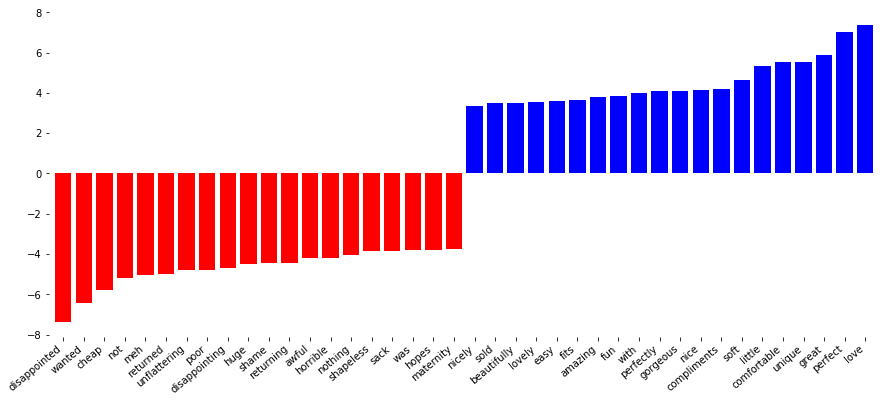

In [36]:
feature_names = tfidf.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr_tfidf_min3_grid.best_estimator_.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

In [29]:
tfidf = TfidfVectorizer(min_df=4)
X_train_tfidf4 = tfidf.fit_transform(text_trainval)
X_val_tfidf4 = tfidf.transform(text_testval)
print(X_train_tfidf4.shape)

(17614, 4966)


In [30]:
param_grid = {'C': np.logspace(-3,3,20)}
lr_tfidf_min4_grid = GridSearchCV(LogisticRegression(), param_grid, cv=10,scoring=('roc_auc'))
lr_tfidf_min4_grid.fit(X_train_tfidf4, train_label)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [31]:
print("parameter:", lr_tfidf_min4_grid.best_params_)
print("tfidf_min4 training score :", lr_tfidf_min4_grid.best_score_)

parameter: {'C': 2.976351441631316}
tfidf_min4 training score : 0.9487493187943982


In [37]:
from sklearn.pipeline import make_pipeline
param_grid = { 'logisticregression__C': [100, 10, 1, 0.1, 0.001],
                 'tfidfvectorizer__max_df':[100, 200, 300, 400, 500]}
pipe_max_df = make_pipeline(TfidfVectorizer(), LogisticRegression(), memory="cache_folder")  
grid_max_df = GridSearchCV(pipe_max_df, param_grid, scoring='roc_auc') 

In [38]:
grid_max_df.fit(text_trainval, train_label)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory='cache_folder',
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.001], 'tfidfvectorizer__max_df': [100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
print("parameter:", grid_max_df.best_params_)
print("tfidf_min4 training score :", grid_max_df.best_score_)

parameter: {'logisticregression__C': 1, 'tfidfvectorizer__max_df': 500}
tfidf_min4 training score : 0.9186270614449624


In [40]:
tfidf = TfidfVectorizer(max_df=500)
X_train_tfidf500 = tfidf.fit_transform(text_trainval)
X_val_tfidf500 = tfidf.transform(text_testval)
print(X_train_tfidf500.shape)

(17614, 12730)


In [41]:
lr = LogisticRegression(C = 1).fit(X_train_tfidf500, train_label)

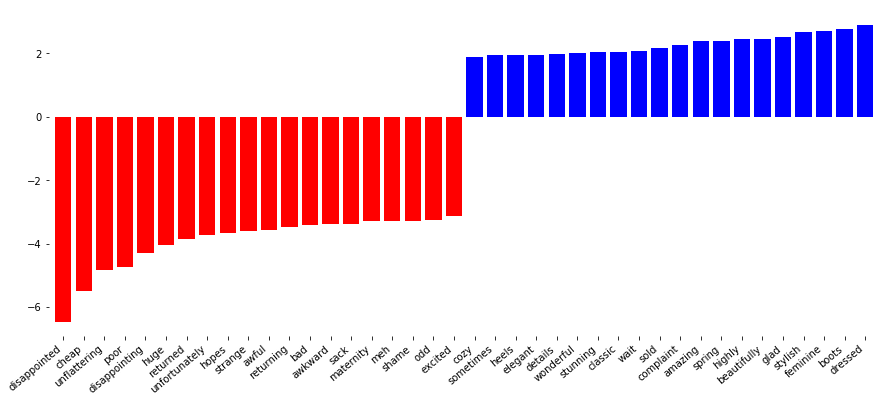

In [42]:
feature_names = tfidf.get_feature_names()
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(feature_names), top_n=20, rotation=40)
ax = plt.gca()

Conclusion from task 2:  Best model: TfidfVectorizer with min_df = 3 and'C': 2.976 score = 0.9488

In [44]:
print("tfidf_min3 test set score :", lr_tfidf_min3_grid.score(X_val_tfidf3, test_label))

tfidf_min3 test set score : 0.9427961697534094


## 3 n-grams (30Pts)

In [14]:
text_trainval, train_label = train_tr['tr'].values.astype('U'),np.array(train[['Recommended']]).ravel()
text_testval, test_label = test_tr['tr'].values.astype('U'), np.array(test[['Recommended']]).ravel()

#### 3.1 Using your current best model, try changing from unigrams to n-grams of varying length. What provides the best performance? Visualize the coefficients. Try visualizing only the higher-order n-grams that are important.


Answer: Our current best model is TfidfVectorizer with min_df = 3 and logisticRegression with C = 2.976351441631316.


After GridSearch ngram_range, we got best score is 0.951879 and parameter is ngram_range: (1, 2)

In [45]:
from sklearn.pipeline import make_pipeline
param_grid = {'tfidfvectorizer__ngram_range':[(2, 2),(3, 3),(4, 4),(1, 2),(1, 3),(1, 4)]}
pipe_ngram = make_pipeline(TfidfVectorizer(min_df = 3), LogisticRegression(C = 2.976351441631316), memory="cache_folder")  
grid_ngram = GridSearchCV(pipe_ngram, param_grid, scoring='roc_auc') 

In [47]:
grid_ngram.fit(text_trainval, train_label)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory='cache_folder',
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tfidfvectorizer__ngram_range': [(2, 2), (3, 3), (4, 4), (1, 2), (1, 3), (1, 4)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [53]:
print("parameter:", grid_ngram.best_params_)
print("tfidf_ngram training score :", grid_ngram.best_score_)

parameter: {'tfidfvectorizer__ngram_range': (1, 2)}
tfidf_ngram training score : 0.9518795994378435


In [49]:
tfidf_ngram = TfidfVectorizer(min_df=3,ngram_range=(1, 2))
X_train_ngram = tfidf_ngram.fit_transform(text_trainval)
X_val_ngram = tfidf_ngram.transform(text_testval)

In [50]:
lr = LogisticRegression(C = 2.976351441631316).fit(X_train_ngram, train_label)

Text(0.5,1,'min_df = 3 with (1-2 gram)')

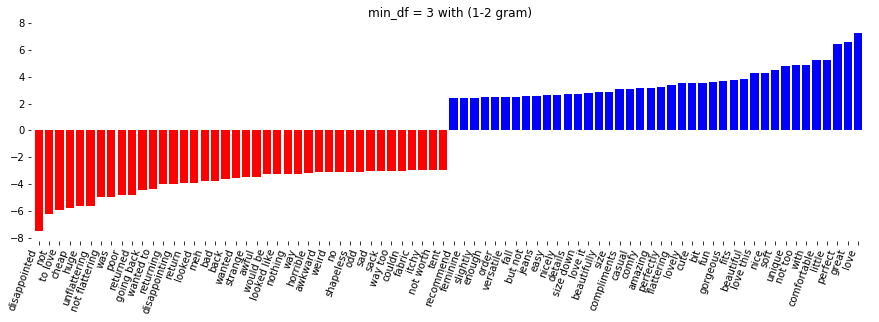

In [51]:
plt.figure(figsize=(15, 4))
plot_important_features(lr.coef_.ravel(), np.array(tfidf_ngram.get_feature_names()), top_n=40, rotation=70)
plt.title("min_df = 3 with (1-2 gram)")

#### 3.2 Try using character n-grams. Visualize the coefficients. Can we learn something from this?

We got character n-grams highest training set score 0.952 with C = 10,ngram_range = (2, 5). By visualizing coefficients , we found some punctuation and less semantically characters have high coefficients.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

param_grid = {"logisticregression__C": [100, 10, 1, 0.1, 0.001],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2),(2, 3), (2, 5)]
             }
pipe_char_ngram = make_pipeline(TfidfVectorizer(analyzer="char"), LogisticRegression(), memory="cache_folder")
grid_char_ngram = GridSearchCV(pipe_char_ngram, param_grid = param_grid, cv=5, scoring="roc_auc")
                   

In [11]:
grid_char_ngram.fit(text_trainval, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory='cache_folder',
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [100, 10, 1, 0.1, 0.001], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (2, 3), (2, 5)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [12]:
print("parameter:", grid_char_ngram.best_params_)
print("tfidf_ngram training score :", grid_char_ngram.best_score_)

parameter: {'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (2, 5)}
tfidf_ngram training score : 0.9523625728265607


In [13]:
print("tfidf_ngram score:{:.3f}".format(grid_char_ngram.score(text_testval, test_label)))

tfidf_ngram score:0.948


In [17]:
tfidf_char_ngram = TfidfVectorizer(analyzer="char", ngram_range = (2, 5))
X_train_char_ngram = tfidf_char_ngram.fit_transform(text_trainval)
X_val_char_ngram = tfidf_char_ngram.transform(text_testval)

In [18]:
lr = LogisticRegression(C = 10).fit(X_train_char_ngram, train_label)

Text(0.5,1,'character ngram with (2,5 gram)')

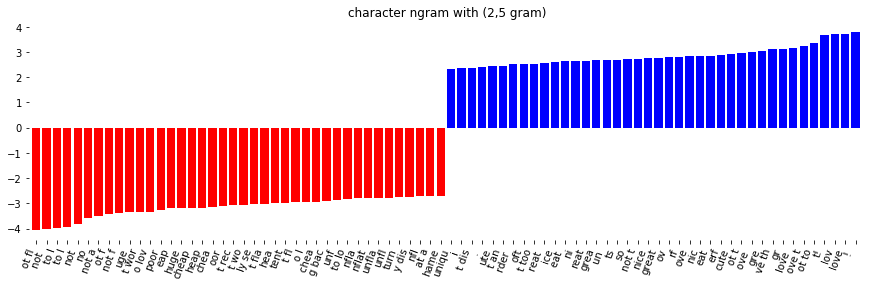

In [21]:
plt.figure(figsize=(15, 4))
plot_important_features(lr.coef_.ravel(), np.array(tfidf_char_ngram.get_feature_names()), top_n=40, rotation=70)
plt.title("character ngram with (2,5 gram)")

#### 3.3 Investigate how min_df and the use of stop-words changes the number of features when using word n-grams, and how they change the score.


##### min_df

In [119]:
param_grid = {"logisticregression__C": [ 3, 1, 0.1],
              "tfidfvectorizer__ngram_range": [(1, 5),(2, 5), (3, 8)],
              "tfidfvectorizer__min_df" :[2,3,4]
             }
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression(),memory="cache_folder")
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring="roc_auc")
              

In [120]:
grid.fit(text_trainval, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory='cache_folder',
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [3, 1, 0.1], 'tfidfvectorizer__ngram_range': [(1, 5), (2, 5), (3, 8)], 'tfidfvectorizer__min_df': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [121]:
print("tfidf_ngram score:{:.3f}".format(grid.score(text_testval, test_label)))

tfidf_ngram score:0.952


In [122]:
grid.best_params_

{'logisticregression__C': 3,
 'tfidfvectorizer__min_df': 4,
 'tfidfvectorizer__ngram_range': (1, 5)}

##### stop_words

In [124]:
param_grid = {"logisticregression__C": [ 3, 2.5, 2,1],
              "tfidfvectorizer__ngram_range": [(1, 5), (1, 7),  (2, 5), (3, 8), (5, 5)],
              "tfidfvectorizer__min_df":[3,4,5]
             }
pipe = make_pipeline(TfidfVectorizer(stop_words="english"), LogisticRegression())
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring="roc_auc")

In [125]:
grid.fit(text_trainval, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [3, 2.5, 2, 1], 'tfidfvectorizer__ngram_range': [(1, 5), (1, 7), (2, 5), (3, 8), (5, 5)], 'tfidfvectorizer__min_df': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [126]:
print("tfidf_ngram score with stop words:{:.3f}".format(grid.score(text_testval, test_label)))

tfidf_ngram score with stop words:0.941


In [127]:
grid.best_params_

{'logisticregression__C': 3,
 'tfidfvectorizer__min_df': 3,
 'tfidfvectorizer__ngram_range': (1, 5)}

## 4 Model Tuning (again) 10 Pts

#### 4.1 Revisit your choice of model. Compare different linear models with L1 and L2 penalty on the best performing features from Task 3. 

#### The best min-df = 4 and the best ngram-grid = (1,5) without stop words

In [144]:
#####Lasso with L1 penalty
from sklearn.linear_model import Lasso

In [145]:
param_grid = {"lasso__alpha": np.logspace(-3,3,20)}
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 5), min_df = 4), Lasso())
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring="roc_auc")

In [146]:
grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__tfidfvectorizer', 'estimator__lasso', 'estimator__tfidfvectorizer__analyzer', 'estimator__tfidfvectorizer__binary', 'estimator__tfidfvectorizer__decode_error', 'estimator__tfidfvectorizer__dtype', 'estimator__tfidfvectorizer__encoding', 'estimator__tfidfvectorizer__input', 'estimator__tfidfvectorizer__lowercase', 'estimator__tfidfvectorizer__max_df', 'estimator__tfidfvectorizer__max_features', 'estimator__tfidfvectorizer__min_df', 'estimator__tfidfvectorizer__ngram_range', 'estimator__tfidfvectorizer__norm', 'estimator__tfidfvectorizer__preprocessor', 'estimator__tfidfvectorizer__smooth_idf', 'estimator__tfidfvectorizer__stop_words', 'estimator__tfidfvectorizer__strip_accents', 'estimator__tfidfvectorizer__sublinear_tf', 'estimator__tfidfvectorizer__token_pattern', 'estimator__tfidfvectorizer__tokenizer', 'estimator__tfidfvectorizer__use_idf', 'estimator__tfidfvectorizer__vocabulary', 'estimator__lasso

In [148]:
grid.fit(text_trainval, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_i...e=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': array([1.00000e-03, 2.06914e-03, 4.28133e-03, 8.85867e-03, 1.83298e-02,
       3.79269e-02, 7.84760e-02, 1.62378e-01, 3.35982e-01, 6.95193e-01,
       1.43845e+00, 2.97635e+00, 6.15848e+00, 1.27427e+01, 2.63665e+01,
       5.45559e+01, 1.12884e+02, 2.33572e+02, 4.83293e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [150]:
grid.best_params_

{'lasso__alpha': 0.001}

In [149]:
print("Lasso with L1 penalty:{:.3f}".format(grid.score(text_testval, test_label)))

Lasso with L1 penalty:0.739


In [131]:
##### Ridge with L2 penalty
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer

In [139]:
param_grid = {"ridge__alpha": np.logspace(-3,3,15)}
pipe = make_pipeline(TfidfVectorizer(ngram_range=(1, 5), min_df = 4), Ridge())
grid = GridSearchCV(pipe, param_grid = param_grid, cv=5, scoring="roc_auc")

In [140]:
grid.fit(text_trainval, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=4,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_i...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': array([1.00000e-03, 2.68270e-03, 7.19686e-03, 1.93070e-02, 5.17947e-02,
       1.38950e-01, 3.72759e-01, 1.00000e+00, 2.68270e+00, 7.19686e+00,
       1.93070e+01, 5.17947e+01, 1.38950e+02, 3.72759e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [141]:
print("Ridge with L2 penalty:{:.3f}".format(grid.score(text_testval, test_label)))

Ridge with L2 penalty:0.951


#### 4.2 Are there any other obvious features to try, or combinations to try out? (Don’t perform them, just list them).

We can still tune other parameters in TF-IDF like:
tokenizer,
lowercase,
max_features

We also can add scaling like standard scale before linear models to make the model more gaussian

Besides that, we can use LSA, LDA to reduce dimension for the document and do topic models analyze.